# Imports

Requires `healpy`, `numpy`, `orphics`, `pixell`, `pymaster`, and `camb`.

In [102]:
import healpy as hp
import numpy as np
from orphics import cosmology, maps
import matplotlib.pyplot as plt
from pixell import lensing as plensing

import os, time

import pymaster as nmt

import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb import model

# Filenames / Locations of sims + masks

Replace as needed, make sure masks have the same `Nside` resolution.
All provided paths to ACT data products (blinded!) are located on NERSC's Perlmutter system.

In [1]:
# healpix maps
GALAXY_MASK = "/path/to/galaxy/mask/here.fits"
# ACT mask needs to be converted to a healpix map first!
# https://github.com/simonsobs/pixell/blob/master/pixell/reproject.py#L115
KAPPA_MASK = "/global/cfs/cdirs/act/data/gfarren/act_mask_20220316_GAL060_rms_70.00_d2sk.fits"

# healpix alms
INPUT_PHIS = "/global/homes/j/jia_qu/files/ACT_blinded_alms/signal_sims/fullskyPhi_alm_00###.fits"
RECON_KAPPAS = "/global/homes/j/jia_qu/files/ACT_blinded_alms/act_lensing_sims/baseline/all_MV_simlensing_mf-sub_mc-corr_MV_#.fits"

# numpy array saved as a file
NORM_CORRECTION = "/global/homes/j/jia_qu/files/ACT_blinded_alms/act_lensing_sims/mc_norm_corrections/all_MV_mc_bias_MV_sims1-400"

FILLER = "#"

# Constants

Change as needed! Number of bandpowers will be `(LMAX_CUT - LMIN) / LperBin`.

In [37]:
LMIN = 40
LMAX = 6000
LMAX_CUT = 1000
LperBin = 40
NSIDE = 2048

# Binning (NaMaster)

In [56]:
# bin cls according to some scheme defined by b
def bin_spectra(cls, b=None, coupling_matrix_name=None):
    cls_nmt = np.array([cls])
    if coupling_matrix_name is not None:
        wsp = nmt.NmtWorkspace()
        wsp.read_from(coupling_matrix_name)
        return wsp.decouple_cell(wsp.couple_cell(cls_nmt))[0]
    if b is not None:
        assert len(cls_nmt[0]) == b.lmax+1, f"cl size ({str(len(cls_nmt[0]))}) != binning range ({str(b.lmax+1)})"
        return b.bin_cell(cls_nmt)[0]
    
def make_bins(nside=NSIDE,LperBin=50,lmin=LMIN,lmax=LMAX):
    ells    = np.arange(lmax,dtype='int32')
    weights = 1. / LperBin * np.ones_like(ells)
    weights[ells<lmin] = 0
    
    # Now generate the bandpower indices, here by brute force.
    # A -1 means that ell value is not included in any bandpower.
    bpws = np.zeros_like(ells) - 1
    ibin = 0
    while LperBin*(ibin+1)+lmin<lmax:
        bpws[LperBin*ibin+lmin:LperBin*(ibin+1)+lmin] = ibin
        ibin += 1
    # return Nmt binning instance
    return nmt.NmtBin(nside,bpws=bpws,ells=ells,weights=weights)

# assuming linearly spaced
def bin_edges_from_nmt(b, LperBin):
    cents = b.get_effective_ells()
    cents_with_zero = [cents[0] - LperBin] + list(cents)[:-1]
    
    # needs extra 0.5 additive factor if LperBin is even
    return 0.5 * ((1 - (LperBin % 2)) + np.array(cents) + np.array(cents_with_zero))

# return index for max bin index within a cutoff
def max_bin(bin_edges, cutoff):
    return np.argmax(np.nonzero(bin_edges < cutoff)[0]) + 1

Here's a wrapper for CAMB to read parameters from a .ini file to generate theory spectra that can be reordered by this `orphics` function. I don't use it in this notebook as it can take some time to run CAMB for a higher `lmax`.

In [5]:
# most code directly copied from https://github.com/msyriac/orphics/blob/master/orphics/cosmology.py
def theory_cls_from_ini(ini_filename, windows, lmax, nonlinear=True):
    pars = camb.read_ini(ini_filename)
    pars.set_for_lmax(lmax, lens_potential_accuracy=1)
    pars.Want_CMB = False 
    #NonLinear_both or NonLinear_lens will use non-linear corrections
    if nonlinear:
        pars.NonLinear = model.NonLinear_both
    else:
        pars.NonLinear = None

    sws = []
    aws = dict(windows)
    wkeys = list(aws.keys())
    for key in wkeys:
        assert ('P' not in key) and ('x' not in key), "The letters P and x are not allowed in window names."
        ws = aws[key]
        stype = ws['stype'].strip().lower()
        if stype=='counts':
            bias = ws['b']
            try:
                dlog10Ndm = ws['dlog10Ndm']
            except:
                dlog10Ndm = -0.2
        elif stype=='lensing':
            bias = 0
            dlog10Ndm = 0
        else:
            raise ValueError
        wtype = ws['wtype'].strip().lower()
        if wtype=='gaussian':
            wfunc = GaussianSourceWindow
            redshift = ws['zmean']
            sigma = ws['zsigma']
            sws = sws + [wfunc(source_type=stype,bias=bias,dlog10Ndm=dlog10Ndm,redshift=redshift,sigma=sigma)]
        elif wtype=='spline':
            wfunc = SplinedSourceWindow
            zs = ws['zs']
            dndz = ws['dndz']
            sws = sws + [wfunc(source_type=stype,bias=bias,dlog10Ndm=dlog10Ndm,z=zs,W=dndz)]
        else:
            raise ValueError

    pars.SourceWindows = [*sws]
    results = camb.get_results(pars)
    cls = results.get_source_cls_dict()
    odict = {}
    ls = np.arange(cls['PxP'].size)    
    for key in cls.keys():
        w1,w2 = key.split('x')
        if w1=='P':
            mul1 = 1./2.
            ow1 = 'CMB'
        else:
            a,ind = w1[0],int(w1[1:])
            assert a=='W'
            assert ind>0
            ow1 = wkeys[ind-1]
            with np.errstate(divide='ignore',invalid='ignore'):                     
                mul1 = 1./np.sqrt(ls*(ls+1.))
        if w2=='P':
            mul2 = 1./2.
            ow2 = 'CMB'
        else:
            a,ind = w2[0],int(w2[1:])
            assert a=='W'
            assert ind>0
            ow2 = wkeys[ind-1]
            with np.errstate(divide='ignore',invalid='ignore'):                     
                mul2 = 1./np.sqrt(ls*(ls+1.))
                
        mul = mul1 * mul2 * 2. * np.pi
        odict[f'{ow1}x{ow2}'] = cls[key] * mul
        
    return odict

# Transfer function

The commonly defined transfer function, or $T(l)$, is computed here as the following:

$$
T(l) = \dfrac{\dfrac{1}{N} \displaystyle\sum_{\text{sim } i}^{N} \text{NmtBin}\left(C^{\hat{\kappa} X}_{i, NMT} \right)}{\text{NmtBin}\left(C^{\kappa X}_{\text{CAMB}}\right)}
$$

where $X$ refers to either the input lensing convergence $\kappa$ or a correlated galaxy field $g$ generated by populating a galaxy simulation so that it has the same auto and cross spectra as the provided theory (see `orphics.maps.generate_correlated_alm`).

The denominator is computed according to cosmological parameters used to create the lensing simulations written in a CAMB .ini file to result in a theory spectrum that is binned by NaMaster (by coupling and then decoupling with a mode-coupling cell), and the numerator is computed as a mean over sims of a NaMaster-computed pseudo-Cl between the reconstructed convergence $\hat{\kappa}$ and $X$, ensuring that the binning of the denominator is done exactly the same way as the numerator.

This is what we should *divide* our initial measurement by to correct the data products for any mode-coupling or fractional sky effects that we expect from the simulations. 

For this case, we will treat $X = \kappa$.

## Denominator

The numerator is simply the ACT DR6 lensing auto-spectrum theory binned with NaMaster. Both the numerator and denominator will be binned up to a much higher ell (`LMAX`) than the desired limit (`LMAX_CUT`) to prevent power leakage at the smallest considered scales, and then cut at that limiting bin number after all binning is done.

In [48]:
ells, dr6_lensing_clkk = np.loadtxt("theory-clkk-cls.txt", usecols=[0,1], unpack=True)
clkk_theory = dr6_lensing_clkk[ells < 3*NSIDE]

# usually monopole and dipole of lensing auto-spectrum is set to zero
# if included at all, but needs to be included for binning
if ells[0] > 0:
    clkk_theory = np.append(np.array([0] * int(ells[0])),
                            clkk_theory)

In [123]:
# Now bin with NaMaster. We will reuse "b"!
b = make_bins(nside=NSIDE,LperBin=40,lmin=LMIN,lmax=LMAX)

# cut to LMAX_CUT
clkk_theory_binned = bin_spectra(clkk_theory, b)[:max_bin(b.get_effective_ells(), LMAX_CUT)]

## Numerator

We have to now iterate over sims and compute the mean pseudo-Cls with the masks passed into NaMaster.
Here is the iterating function:

In [131]:
START_INDEX = 2
END_INDEX = 101 # inclusive

COUPLING_MATRIX_NAME = "nmt_transfer_function_coupling_matrix.fits"

# iterate a function "fn" over all sims with some indexing format
# return dict d where d[idx] = fn(sims[idx], idx)
# if is_healpix_map is set to False, assume the sims are alm files
def iterate_over_kappa_sims(fn, sim_start=START_INDEX, sim_end=END_INDEX,
                            is_healpix_map=True, common_format="sims_####.fits", formatter="#"):
    data_dict = {}

    for i in range(sim_start, sim_end+1):
        # find appropriate file name for a given file index
        ndigits = common_format.count(formatter)
        filename = common_format.replace(formatter * ndigits, str(i).zfill(ndigits))
        
        try:
            if is_healpix_map:
                filedata = hp.read_map(filename)
            else:
                # alm indices 0 + 1 can be NaNs due to convention
                filedata = np.nan_to_num(hp.read_alm(filename)).astype(np.complex128)
            
            print(f"Running index #{str(i)}.")
            print(f"Filename: {filename}")
            fn(filedata, data_dict, i)
            # for memory purposes
            del filedata

        except FileNotFoundError:
            print(f"Could not find {filename}.")
            continue
    
    return data_dict

And the helper function it needs to iterate:

In [132]:
# now defining the "fn" to be iterated over in the definition above
# "kappa" here refers to the reconstructed kappa sims
def iterator_clkk(kappa, data_dict, idx):
    # the index # "idx" also specifies the input potential filename
    # assuming recon sim index # == input sim index #
    input_kappa_filename = INPUT_PHIS.replace(FILLER * INPUT_PHIS.count(FILLER),
                                              str(idx).zfill(INPUT_PHIS.count(FILLER)))
    print(f"Input kappa: {input_kappa_filename}")

    # the input alms are lensing potentials,
    # so convert them to kappa alms stored as double complex values
    input_kappa = plensing.phi_to_kappa(hp.read_alm(input_kappa_filename)).astype(np.complex128)
    
    # reconstructed sims need a multiplicative MC norm correction
    # comment these lines out if MC norm correction is already applied!
    
    # mc_corr = np.loadtxt(NORM_CORRECTION)
    
    # but these might do strange things to the monopole and dipole terms
    # so let's first set those to zero
    
    # mc_corr[0] = 0.
    # mc_corr[1] = 0.
    # kappa = hp.almxfl(kappa, mc_corr)
    
    # run NaMaster!
    kmask = hp.read_map(KAPPA_MASK)
    gmask = hp.read_map(GALAXY_MASK)
    
    kmap = hp.alm2map(input_kappa, NSIDE)
    khat_map = hp.alm2map(kappa, NSIDE)

    # The reconstructed lensing sims are made from pre-masked CMB temperature maps,
    # so the quadratic estimator results in a lensing map effectively masked twice by the ACT mask
    field_k_hat = nmt.NmtField(kmask**2, [khat_map], masked_on_input=True)
    # No need to worry about the input lensing fields, since they are generated on the full sky
    field_k = nmt.NmtField(gmask, [kmap], masked_on_input=False)

    # only compute coupling matrix if not pre-computed / saved before
    w = nmt.NmtWorkspace()
    if os.path.isfile(COUPLING_MATRIX_NAME):
        print("Reading coupling matrix from disk.")
        w.read_from(COUPLING_MATRIX_NAME)
    else:
        w.compute_coupling_matrix(field_k, field_k_hat, b)
        print("Writing coupling matrix to disk.")
        w.write_to(COUPLING_MATRIX_NAME)

    # use coupling matrix to generate pseudo-cls
    clkk = w.decouple_cell(nmt.compute_coupled_cell(field_k, field_k_hat))[0]
    nmtells = b.get_effective_ells()
    
    # only run to desired lmax cut
    data_dict[idx] = clkk[:max_bin(nmtells, LMAX_CUT)]

Now we iterate over the desired number of sims (can take O(hours) for multiple hundreds of sims!)

In [ ]:
time1 = time.time()
clkk_data = iterate_over_kappa_sims(iterator_clkk, sim_start=START_INDEX, sim_end=END_INDEX,
                                    is_healpix_map=False, common_format=RECON_KAPPAS, formatter=FILLER)
print("--")
print(f"Time elapsed: {time.time()-time1:0.5f} seconds")

Compute the mean of the sim-based spectrum computation over the sims for the transfer function as well as the scatter via covariance matrix from the sims to estimate error bars for our transfer function measurement:

In [134]:
clkk_sims = np.array([clkk_data[k] for k in clkk_data.keys()])

clkk_mean_sims = np.mean(clkk_sims, axis=0)

# computing error bars (on the mean) from sims covariance
errs = 1/np.sqrt(END_INDEX - START_INDEX + 1) * np.sqrt(np.diag(np.cov(clkk_sims.T)))

# T(l) results and plots

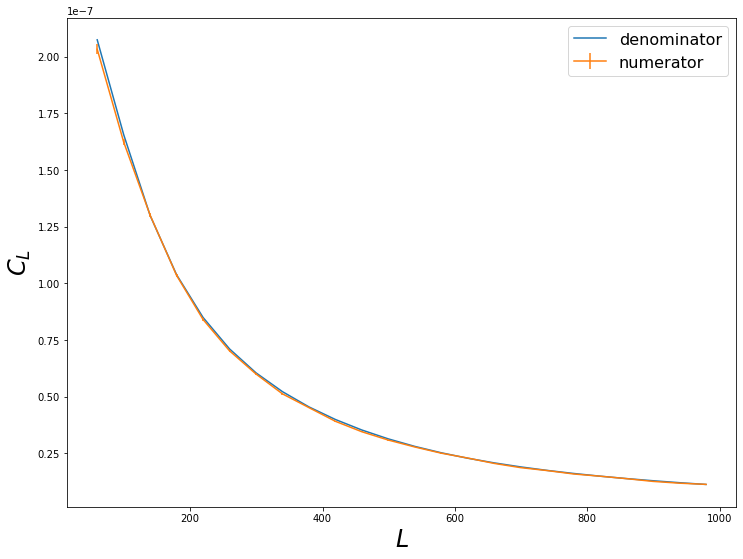

In [135]:
# cut x-axis ells to LMAX_CUT
ells = b.get_effective_ells()
ells = ells[:max_bin(ells, LMAX_CUT)]

plt.figure(figsize=(12,9))
plt.plot(ells, clkk_theory_binned, label="denominator")
plt.errorbar(ells, clkk_mean_sims, errs, label="numerator")
plt.xlabel(r"$L$", size=24)
plt.ylabel(r"$C_L$", size=24)
plt.legend(prop={'size': 16})
plt.show()

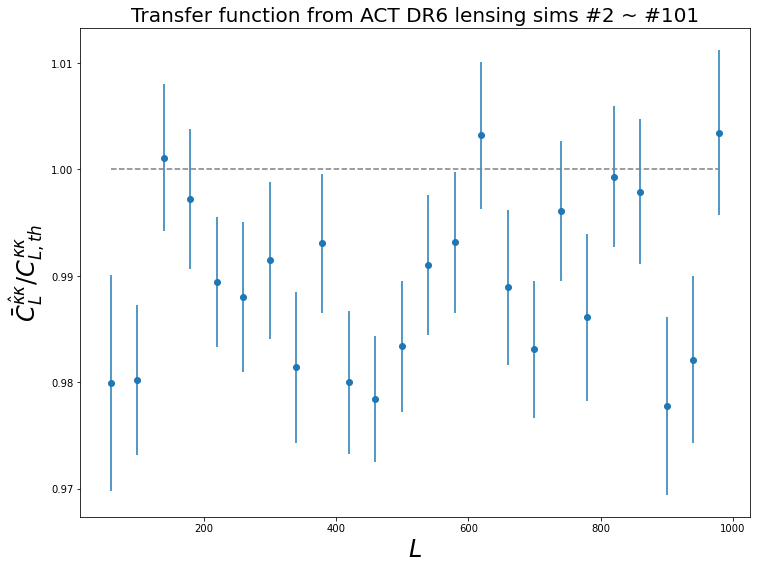

In [138]:
plt.figure(figsize=(12,9))
plt.title(f"Transfer function from ACT DR6 lensing sims #{START_INDEX} ~ #{END_INDEX}", size=20)
plt.errorbar(ells, clkk_mean_sims / clkk_theory_binned, errs / clkk_theory_binned, fmt='o')
plt.plot(ells, ells * 0. + 1., '--', color='grey')
plt.xlabel(r"$L$", size=24)
plt.ylabel(r"$\bar{C}_L^{\hat{\kappa} \kappa} / C_{L,th}^{\kappa \kappa}$", size=24)
plt.show()

In [139]:
# Write to disk
np.savetxt("act-dr6-transfer-function.txt", np.column_stack((ells,
                                                             clkk_mean_sims / clkk_theory_binned,
                                                             errs / clkk_theory_binned)))